In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model using automap_base()
Base = automap_base()

# reflect the tables with Base.prepare(), passing in the engine and reflect=True
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found with Base.classes
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our Session() and bind it to the engine
session = Session(bind=engine)

In [10]:
inspector = inspect(engine)
meas_insp = inspector.get_columns('measurement')
pd.DataFrame(meas_insp)

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


In [11]:
stat_insp = inspector.get_columns('station')
pd.DataFrame(stat_insp)

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data

In [12]:
# Find the last date in the database
last_date = (session
                 .query(measurement.date, measurement.prcp)                      
                 .order_by(measurement.date.desc())
                 .first())

In [13]:
last_date[0]

'2017-08-23'

In [14]:
my_date = datetime.strptime(last_date[0], "%Y-%m-%d")

In [15]:
# Calculate the date 1 year ago from the last data point in the database
# Use the datetime.timedelta() function to help calculate the difference of one year, 12 months, or 365 days
year_ago = dt.date(my_date.year, my_date.month, my_date.day) - dt.timedelta(days=365)

In [16]:
# Use session.query() to retrieve the date and prcp columns, .filter() by the date you calculated above, and selecting .all() results
(session
 .query(measurement.date, measurement.prcp, measurement.station)                      
 .filter(measurement.date >= year_ago)
 .all())

[('2016-08-23', 0.0, 'USC00519397'),
 ('2016-08-24', 0.08, 'USC00519397'),
 ('2016-08-25', 0.08, 'USC00519397'),
 ('2016-08-26', 0.0, 'USC00519397'),
 ('2016-08-27', 0.0, 'USC00519397'),
 ('2016-08-28', 0.01, 'USC00519397'),
 ('2016-08-29', 0.0, 'USC00519397'),
 ('2016-08-30', 0.0, 'USC00519397'),
 ('2016-08-31', 0.13, 'USC00519397'),
 ('2016-09-01', 0.0, 'USC00519397'),
 ('2016-09-02', 0.0, 'USC00519397'),
 ('2016-09-03', 0.0, 'USC00519397'),
 ('2016-09-04', 0.03, 'USC00519397'),
 ('2016-09-05', None, 'USC00519397'),
 ('2016-09-06', None, 'USC00519397'),
 ('2016-09-07', 0.05, 'USC00519397'),
 ('2016-09-08', 0.0, 'USC00519397'),
 ('2016-09-09', 0.03, 'USC00519397'),
 ('2016-09-10', 0.0, 'USC00519397'),
 ('2016-09-11', 0.05, 'USC00519397'),
 ('2016-09-12', 0.0, 'USC00519397'),
 ('2016-09-13', 0.02, 'USC00519397'),
 ('2016-09-14', 1.32, 'USC00519397'),
 ('2016-09-15', 0.42, 'USC00519397'),
 ('2016-09-16', 0.06, 'USC00519397'),
 ('2016-09-17', 0.05, 'USC00519397'),
 ('2016-09-18', 0.0, 'U

In [17]:
# Save the query results as a Pandas DataFrame() and set the index to the date column
results = []
for rain in [1]:
    results += list(session
                     .query(measurement.date, measurement.prcp, measurement.station)                      
                     .filter(measurement.date >= year_ago)
                     .all())

results_df = pd.DataFrame(results).set_index('date')

In [18]:
results_df

,prcp,station
date,,
2016-08-23,0.00,USC00519397
2016-08-24,0.08,USC00519397
2016-08-25,0.08,USC00519397
2016-08-26,0.00,USC00519397
2016-08-27,0.00,USC00519397
...,...,...
2017-08-19,0.09,USC00516128
2017-08-20,NaN,USC00516128
2017-08-21,0.56,USC00516128


In [19]:
# obtain the unique station names for use in the dictionary later.
results_df['station'].unique()

array(['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948',
       'USC00519523', 'USC00519281', 'USC00516128'], dtype=object)

In [20]:
# Sort the dataframe by date
results_df['station'].sort_index()

date
2016-08-23    USC00519397
2016-08-23    USC00517948
2016-08-23    USC00519281
2016-08-23    USC00514830
2016-08-23    USC00513117
                 ...     
2017-08-22    USC00519523
2017-08-23    USC00514830
2017-08-23    USC00519397
2017-08-23    USC00519523
2017-08-23    USC00516128
Name: station, Length: 2230, dtype: object

In [21]:
results_df.groupby('station').count()

,prcp
station,
USC00513117,343
USC00514830,265
USC00516128,328
USC00517948,60
USC00519281,352
USC00519397,359
USC00519523,314


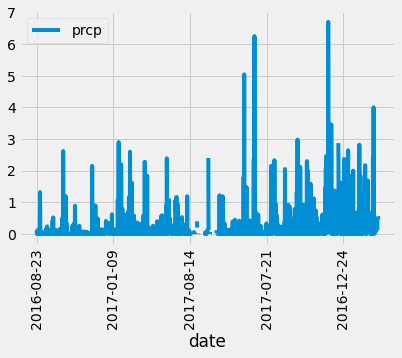

In [37]:
results_df.plot(rot=90)
plt.savefig("Images/Precipitation.png")
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
results_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Design a query to show how many stations are available in this dataset


In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Station table
most_active_stn = (session
                     .query(measurement.station, func.count(measurement.prcp))                      
                     .group_by(measurement.station)
                     .order_by(func.count(measurement.prcp).desc())
                     .all())

In [25]:
most_active = most_active_stn[0][0]
most_active

'USC00519281'

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

# The most active station ID from the previous query is: 'USC00519281'

(session
 .query(measurement.station, 
        func.min(measurement.tobs), 
        func.max(measurement.tobs), 
        func.avg(measurement.tobs))                      
 .filter(measurement.station == most_active)
 .all())

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
(session
 .query(measurement.station, func.count(measurement.tobs))                      
 .group_by(measurement.station)
 .order_by(func.count(measurement.tobs).desc())
 .all())

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = []
for rain in [1]:
    temp_results += list(session
                     .query(measurement.date, measurement.station, measurement.tobs)                      
                     .filter(measurement.station == most_active)
                     .filter(measurement.date >= year_ago)
                     .all())

temp_results_df = pd.DataFrame(temp_results).set_index('date')

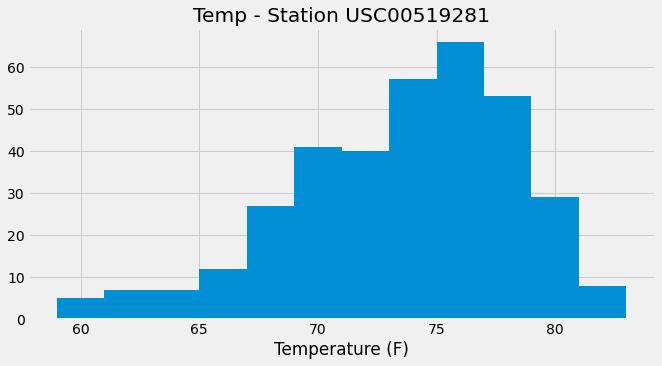

In [29]:
plt.figure(figsize=(10,5))
plt.xlabel("Temperature (F)")
plt.title(f"Temp - Station {most_active}")
plt.hist(temp_results_df['tobs'],bins=12)
plt.savefig("Images/Temp_station.png")
plt.show()

## Bonus Challenge Assignment

In [30]:
# # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# # and return the minimum, average, and maximum temperatures for that range of dates
# def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    
#     return (session.query(func.min(measurement.tobs), 
#                          func.avg(measurement.tobs), 
#                          func.max(measurement.tobs))
#                     .filter(measurement.date >= start_date)
#                     .filter(measurement.date <= end_date)
#                     .all())

# # function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# print(calc_temps('2011-02-28', '2011-03-05'))

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

# def daily_normals(date):
#     """Daily Normals.
    
#     Args:
#         date (str): A date string in the format '%m-%d'
        
#     Returns:
#         A list of tuples containing the daily normals, tmin, tavg, and tmax
    
#     """
#     return (session.query(func.min(measurement.tobs), 
#                           func.avg(measurement.tobs), 
#                           func.max(measurement.tobs))
#                    .filter(func.strftime("%m-%d", measurement.date) == date)
#                    .all())
    
# daily_normals("01-01")

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
